In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
#load all the data

df_single_channel= pd.read_csv('Patch-seq log - Channel recordings.csv')
df_mouse = pd.read_excel('Patch-seq log.xlsx','Mouse PatchSeq')
df_human = pd.read_excel('Patch-seq log.xlsx','Human PatchSeq')


In [31]:
#create marker for single channel recordings

cells = list(df_single_channel['Cell'])
df_mouse['single_channel'] = df_mouse['File'].map(lambda x: True if x in cells else False)
df_human['single_channel'] = df_human['Unnamed: 4'].map(lambda x: True if x in cells else False)


In [32]:
#now get the donors for each cell

df_single_channel['donor'] = df_single_channel['Cell'].apply(lambda x: x[:-9])
df_mouse['donor'] = df_mouse['File'].apply(lambda x: str(x)[:-9])
df_human['donor'] = df_human['Unnamed: 4'].apply(lambda x: str(x)[:-9])

#and mark which cells should be included

donors = list(df_single_channel['donor'])
df_mouse['include'] = df_mouse['donor'].map(lambda x: True if x in donors else False)
df_human['include'] = df_human['donor'].map(lambda x: True if x in donors else False)

In [33]:
#shorten the dataframes so we can concat them

df_mouse = df_mouse[df_mouse['include'] == True]
df_human = df_human[df_human['include'] == True]

mouse_columns = ['File', 'Slice health', 'Cell Health', 'Post patch?', 'patch duration', 
                 'single_channel', 'include', 'Lims tube id', 'BA total conc. (pg/uL)', 'BA conc. >400 (pg/uL)']
human_columns = ['Unnamed: 4', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 24', 'Unnamed: 31', 
                 'single_channel', 'include', 'Unnamed: 44', 'Unnamed: 49', 'Unnamed: 52']
df_mouse = df_mouse[mouse_columns]
df_human = df_human[human_columns]

#rename the human columns to match the mouse
df_human = df_human.rename(index = str, columns ={
    'Unnamed: 4' : 'File',
    'Unnamed: 18': 'Slice health',
    'Unnamed: 19': 'Cell Health',
    'Unnamed: 24': 'Post patch?',
    'Unnamed: 31': 'patch duration',
    'Unnamed: 44': 'Lims tube id',
    'Unnamed: 49': 'BA total conc. (pg/uL)',
    'Unnamed: 52': 'BA conc. >400 (pg/uL)'
})

df = pd.concat([df_mouse, df_human])

In [6]:
#get some numbers from LIMS
import pg8000

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        cursor.close()
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

In [7]:
lims_query = "SELECT ra.amplified_quantity_ng, ra.name, ra.run_date, ra.percent_cdna_longer_than_400bp, ra.failed, \
ra.cycles, ra.id, rai.sample_id, cell.id, cell.name, cell.created_at, cell.patched_cell_container \
FROM specimens cell \
LEFT JOIN rna_amplification_inputs rai ON rai.sample_id = cell.id \
LEFT JOIN rna_amplifications ra ON ra.id = rai.rna_amplification_id \
WHERE run_date > '2017-01-01'"

lims_df = get_lims_dataframe(lims_query)

In [8]:
#merge on the single channel dataframe
df = pd.merge(df, lims_df, how = 'left', left_on = 'File', right_on = 'name')
df_test = pd.merge(df, lims_df, how = 'left', left_on = 'Lims tube id', right_on = 'patched_cell_container')

In [9]:
df.head()

,File,Slice health,Cell Health,Post patch?,patch duration,single_channel,include,Lims tube id,BA total conc. (pg/uL),BA conc. >400 (pg/uL),amplified_quantity_ng,name,run_date,percent_cdna_longer_than_400bp,created_at,failed,patched_cell_container,sample_id,cycles,id
0,Ctgf-T2A-dgCre;Ai14-341051.05.02.01,2,NaN,Nucleated,9.46667,True,True,P8S4_170818_351_A01,5868,2717,71.550,Ctgf-T2A-dgCre;Ai14-341051.05.02.01,2017-08-22 07:00:00,0.462944,2017-08-18 17:54:48.694918,False,P8S4_170818_351_A01,610762174.0,21.0,610762174.0
1,Ctgf-T2A-dgCre;Ai14-341051.04.02.01,NaN,NaN,NaN,NaN,False,True,P6S4_170818_352_A01,2822,922,44.505,Ctgf-T2A-dgCre;Ai14-341051.04.02.01,2017-08-22 07:00:00,0.326766,2017-08-18 18:34:48.051095,False,P6S4_170818_352_A01,610785779.0,21.0,610785779.0
2,Pvalb-IRES-Cre;Ai14-344091.04.01.01,3,NaN,Nucleated,6.2,False,True,P2S4_170906_056_A01,895.5,563.269,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,Pvalb-IRES-Cre;Ai14-344091.04.01.02,4,NaN,Nucleated,6.8,False,True,P2S4_170906_057_A01,1121.6,822.133,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,Sst-IRES-Cre;Ai14-346778.03.02.01,3,NaN,Nucleated,11.6667,False,True,P2S4_170911_051_A01,988.4,638.506,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN


<Container object of 2 artists>

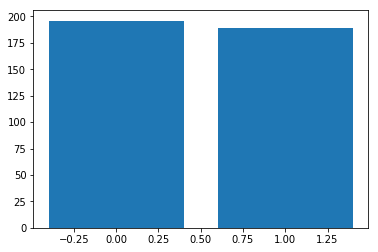

In [10]:
plt.bar([0,1],
        [len(df[df['BA conc. >400 (pg/uL)'].notnull()]),
         len(df[df['BA total conc. (pg/uL)'].notnull()]) ])

In [10]:
df['Post patch?'].unique()

array([u'Nucleated', nan, u'Partial-Nucleus', u'No-Seal',
       u'nucleus_present', u'nucleus_absent', u'entire_cell'], dtype=object)

In [11]:
df.columns

Index([                          u'File',                   u'Slice health',
                          u'Cell Health',                    u'Post patch?',
                       u'patch duration',                 u'single_channel',
                              u'include',                   u'Lims tube id',
               u'BA total conc. (pg/uL)',          u'BA conc. >400 (pg/uL)',
                u'amplified_quantity_ng',                           u'name',
                             u'run_date', u'percent_cdna_longer_than_400bp',
                           u'created_at',                         u'failed',
               u'patched_cell_container',                      u'sample_id',
                               u'cycles',                             u'id'],
      dtype='object')

In [12]:
#there are some NaNs
df = df[df['BA conc. >400 (pg/uL)'].notnull()]
df = df[df['BA total conc. (pg/uL)'].notnull()]
df = df[df['Post patch?'].notnull()]

AttributeError: 'numpy.ndarray' object has no attribute 'find'

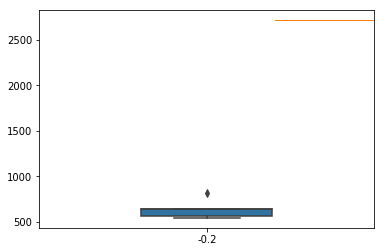

In [13]:
sns.boxplot(x = 'Post patch?', y = 'BA conc. >400 (pg/uL)',
           hue = 'single_channel', data = df)
plt.xticks(rotation = 45)

AttributeError: 'numpy.ndarray' object has no attribute 'find'

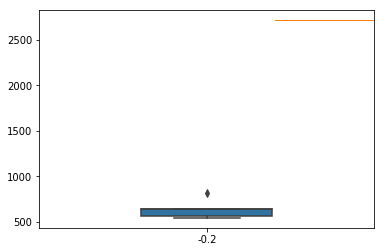

In [16]:
sns.boxplot(x = 'Post patch?', y = 'BA conc. >400 (pg/uL)', 
            hue = 'single_channel', data = df[df['patch duration'] < 30])
plt.xticks(rotation = 45)

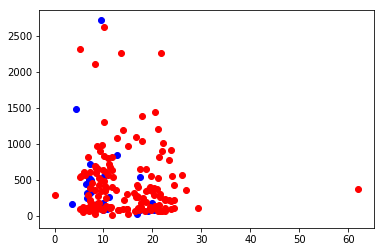

In [15]:
plt.scatter(df[df['single_channel'] == True]['patch duration'], 
            df[df['single_channel'] == True]['BA conc. >400 (pg/uL)'],
           color = 'blue')
plt.scatter(df[df['single_channel'] == False]['patch duration'], 
            df[df['single_channel'] == False]['BA conc. >400 (pg/uL)'],
           color = 'red')

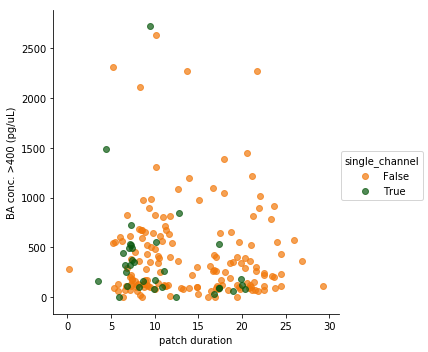

In [22]:
sns.lmplot(x = 'patch duration', y = 'BA conc. >400 (pg/uL)',
          hue = 'single_channel',fit_reg = False, 
           palette = ['#F2790C','#0A590F'],scatter_kws = {'alpha': .7},
           data = df[df['patch duration'] < 30])

In [87]:
df.to_csv('single_channel.csv')

In [37]:
sns.boxplot(x = 'failed', y = 'BA conc. >400 (pg/uL)', 
            hue = 'single_channel', data = df)
plt.xticks(rotation = 45)

ValueError: Could not interpret input 'failed'

In [40]:
df = df[df['single_channel'] == True]

In [34]:
shiny = pd.read_csv("\\\\allen\programs\\celltypes\\workgroups\\rnaseqanalysis\\shiny\\patch_seq\\star\\mouse_patchseq_VISp_20180207_collapsed70_cpm\\mapping.df.with.bp.70.lastmap.csv")
shiny = pd.concat([shiny, pd.read_csv("\\\\allen\\programs\\celltypes\\workgroups\\rnaseqanalysis\\shiny\\patch_seq\\star\\human\\human_patchseq_MTG_20180131\\mapping.df.lastmap.csv")])

In [35]:
df = pd.merge(df, shiny, how = 'left', left_on = 'File', right_on = 'cell_name')
#df = pd.merge(df, shiny, how = 'left', left_on = 'patched_cell_container', right_on = 'patched_cell_container')

In [36]:
df.columns

Index([                        u'File',                 u'Slice health',
                        u'Cell Health',                  u'Post patch?',
                     u'patch duration',               u'single_channel',
                            u'include',                 u'Lims tube id',
             u'BA total conc. (pg/uL)',        u'BA conc. >400 (pg/uL)',
       ...
             u'transgenic_recombinase',          u'transgenic_reporter',
                               u'tube',             u'tube_avg_size_bp',
                   u'tube_contents_nm', u'tube_contents_nm_from_vendor',
                    u'tube_input_fmol',           u'tube_internal_name',
                     u'unmapped_reads',            u'vendor_read_count'],
      dtype='object', length=169)

In [41]:
df[df['res_index']>=.7]['File']

0        Ctgf-T2A-dgCre;Ai14-341051.05.02.01
15       Rbp4-Cre_KL100;Ai14-356489.06.01.02
28       Rbp4-Cre_KL100;Ai14-357010.04.02.01
48       Nkx2-1-CreERT2;Ai14-357183.04.01.01
93      Ntsr1-Cre_GN220;Ai14-361815.03.01.01
95      Ntsr1-Cre_GN220;Ai14-361815.05.01.02
96      Ntsr1-Cre_GN220;Ai14-361815.05.01.03
99         Vip-IRES-Cre;Ai14-363633.03.01.01
100        Vip-IRES-Cre;Ai14-363633.03.01.02
101        Vip-IRES-Cre;Ai14-363633.03.01.03
102        Vip-IRES-Cre;Ai14-363633.03.01.04
106    Slc32a1-IRES-Cre;Ai14-364559.05.02.01
Name: File, dtype: object

In [42]:
len(df)

34

In [38]:
sns.boxplot(x = 'failed', y = 'amplified_quantity_ng', 
            hue = 'single_channel', data = df)
plt.xticks(rotation = 45)

ValueError: Could not interpret input 'failed'

(array([0, 1]), <a list of 2 Text xticklabel objects>)

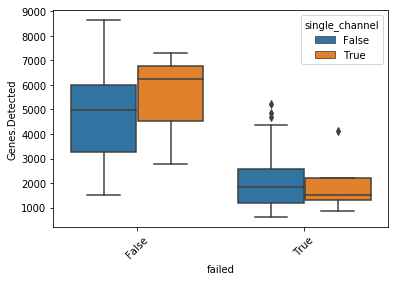

In [22]:
sns.boxplot(x = 'failed', y = 'Genes.Detected', 
            hue = 'single_channel', data = df)
plt.xticks(rotation = 45)

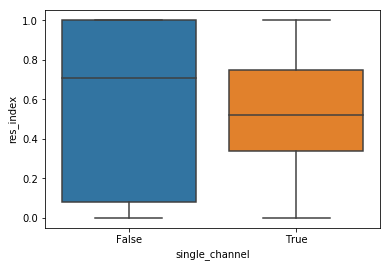

In [129]:
sns.boxplot(x = 'single_channel', y = 'res_index',
            data = df)

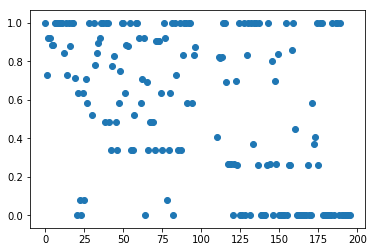

In [107]:
plt.scatter(np.arange(len(df)),df['res_index'])

In [127]:
df[df['res_index']>.7].groupby(['single_channel','cluster_label']).size()

single_channel  cluster_label                               
False           Pvalb  Prdm8                                    4
                Pvalb Il1rapl2                                  2
                Pvalb Vipr2                                     2
                Sst Etv1_4                                      1
                VISp L2/3 IT Agmat                              2
                VISp L5 Endou                                   3
                VISp L5 IT Batf3                                2
                VISp L5 PT C1ql2                                2
                VISp L5 PT Ctxn3                                1
                VISp L5 PT Ptgfr                                1
                VISp L6 CT Dlx4                                 2
                VISp L6 IT Col23a1                              1
                Vip C1ql1                                       1
                Vip Gpc3                                        1
               

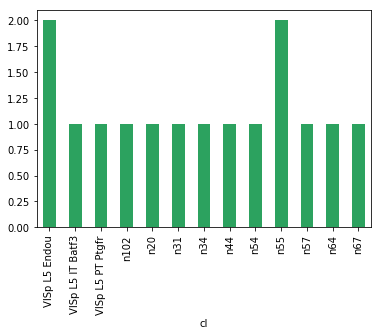

In [58]:
df[df['resolution.index']>.5].groupby('cl').size().plot(kind = 'bar', color = '#2ca25f')

In [44]:
df[df['resolution.index'].notnull()]

,File,Slice health,Cell Health,Post patch?,patch duration,single_channel,include,Lims tube id,BA total conc. (pg/uL),BA conc. >400 (pg/uL),...,transgenic_recombinase,transgenic_reporter,tube,tube_avg_size_bp,tube_contents_nm,tube_contents_nm_from_vendor,tube_input_fmol,tube_internal_name,unmapped_reads,vendor_read_count
0,Ctgf-T2A-dgCre;Ai14-341051.05.02.01,2,NaN,Nucleated,9.46667,True,True,P8S4_170818_351_A01,5868,2717,...,Ctgf,Ai14,PS0921,326.0,5.000000,NaN,5.0,BT170921_01,31123100.0,NaN
14,Rbp4-Cre_KL100;Ai14-357010.05.02.01,3,NaN,nucleus_present,9.06667,False,True,P8S4_171030_352_A01,743.7,429.115,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,6.0,R8S4-17112004,14214900.0,1402445.0
15,Rbp4-Cre_KL100;Ai14-357010.05.02.02,2,NaN,nucleus_present,11.1667,False,True,P8S4_171030_353_A01,1156.8,714.902,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,6.0,R8S4-17112004,12545100.0,1467901.0
16,Rbp4-Cre_KL100;Ai14-357010.05.01.01,3,NaN,nucleus_present,10.5833,False,True,P8S4_171030_354_A01,1039.9,610.421,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,6.0,R8S4-17112004,18972500.0,1698229.0
17,Rbp4-Cre_KL100;Ai14-357010.05.01.02,2,NaN,nucleus_absent,11.4667,False,True,P8S4_171030_355_A01,342.7,120.63,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,5.0,R8S4-17112004,48969500.0,1362347.0
18,Rbp4-Cre_KL100;Ai14-357010.04.01.01,3,NaN,nucleus_absent,8.01667,False,True,P9S4_171030_401_A01,328.9,57.8864,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,3.0,R8S4-17112004,35410300.0,840676.0
19,Rbp4-Cre_KL100;Ai14-357010.04.01.02,3,NaN,nucleus_present,11.3333,False,True,P9S4_171030_402_A01,480.6,108.135,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,4.0,R8S4-17112004,22045900.0,969814.0
20,Rbp4-Cre_KL100;Ai14-357010.03.01.01,4,NaN,nucleus_absent,7.15,False,True,PBS4_171030_503_A01,520.4,206.078,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,3.0,R8S4-17112004,33248900.0,939019.0
21,Rbp4-Cre_KL100;Ai14-357010.03.02.01,3,NaN,nucleus_absent,7.26667,False,True,PBS4_171030_504_A01,290.5,132.468,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,5.0,R8S4-17112004,34807900.0,1222703.0
22,Rbp4-Cre_KL100;Ai14-357010.03.02.02,3,NaN,nucleus_present,7.41667,False,True,PBS4_171030_505_A01,400.4,180.18,...,Rbp4,Ai14,SM-GE643,387.0,4.149407,3.50,6.0,R8S4-17112004,36402800.0,1490658.0


In [100]:
shiny[shiny['cell_name'] == 'Pvalb-IRES-Cre;Ai14-357946.03.02.02']

,CPM.16,CPM.32,CPM.4,CPM.64,CPM.8,Class,Depth,End_pipetteR,Ephys_time,Exclude.1,...,transgenic_recombinase,transgenic_reporter,tube,tube_avg_size_bp,tube_contents_nm,tube_contents_nm_from_vendor,tube_input_fmol,tube_internal_name,unmapped_reads,vendor_read_count
503,5994,5254,6859,3959,6442,NaN,53.5,1000,65.0,No,...,Pvalb-IRES-Cre,Ai14,SM-GE66C,314.0,6.050846,3.95,12,R8S4-17120603,68145,1163563.0


In [105]:
shiny.head()

,CPM.16,CPM.32,CPM.4,CPM.64,CPM.8,Class,Depth,End_pipetteR,Ephys_time,Exclude.1,...,transgenic_recombinase,transgenic_reporter,tube,tube_avg_size_bp,tube_contents_nm,tube_contents_nm_from_vendor,tube_input_fmol,tube_internal_name,unmapped_reads,vendor_read_count
0,5622,4911,6646,3885,6144,NaN,51.5,NaN,NaN,No,...,Ndnf,Ai14,msPSX170321,NaN,5.000000,NaN,5,BT170323_01,75769600,NaN
1,5908,5269,6654,4004,6296,NaN,63.1,200,17.0,No,...,Ndnf,Ai14,SM-GE65H,313.0,5.152589,4.18,8,R8S4-18011005,44403,1079579.0
2,5038,4339,5838,3344,5499,NaN,0,NaN,NaN,No,...,NaN,NaN,PSX160502,NaN,NaN,NaN,5,PSX160502,922030900,NaN
3,5682,5011,6500,3909,6139,NaN,0,NaN,NaN,No,...,NaN,NaN,PSX160511,NaN,NaN,NaN,5,PSX160511,112660400,NaN
4,5705,5063,6507,3955,6139,NaN,43,NaN,NaN,No,...,Ndnf,Ai14,msPSX170321,NaN,5.000000,NaN,5,BT170323_01,52133300,NaN
